In [1]:
import pandas as pd
import nltk
import torch
import numpy as np 
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize


In [2]:
csv = pd.read_csv("labeled_data.csv")
df = pd.DataFrame(csv )

In [3]:
device = torch.device("mps")
device

device(type='mps')

In [4]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [5]:
df["tweet"]

0        !!! RT @mayasolovely: As a woman you shouldn't...
1        !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2        !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3        !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4        !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
                               ...                        
24778    you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779    you've gone and broke the wrong heart baby, an...
24780    young buck wanna eat!!.. dat nigguh like I ain...
24781                youu got wild bitches tellin you lies
24782    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweet, Length: 24783, dtype: object

In [6]:
df[df["hate_speech"]!=0] 

,count,hate_speech,offensive_language,neither,class,tweet
5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria..."
14,3,1,2,0,1,""" bitch get up off me """
17,3,1,2,0,1,""" bitch who do you love """
49,3,1,2,0,1,""" these hoes like niggas that spend money not ..."
...,...,...,...,...,...,...
24753,3,1,2,0,1,you ain't gotta be a dyke to like hoes
24762,3,1,2,0,1,"you got niggas, and i got bitches."
24773,3,1,2,0,1,you niggers cheat on ya gf's? smh....
24776,3,3,0,0,0,you're all niggers


In [7]:
df["class"].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

<AxesSubplot: xlabel='class', ylabel='count'>

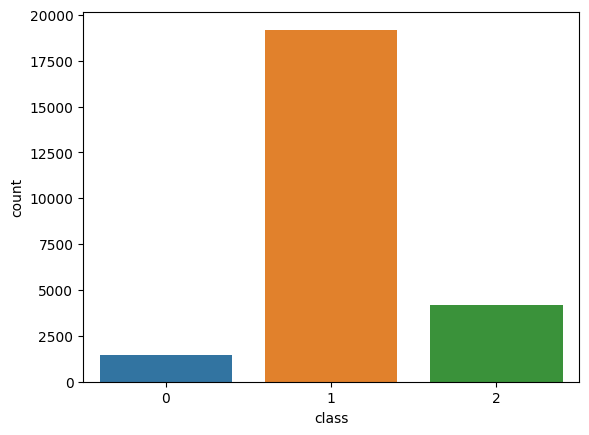

In [8]:
sns.countplot(data=df, x="class")

    < Our data is imbalanced to see the difference we will observe both imbalanced and the balanced results>

# Train Test Splitting

In [9]:
'''

X,y = df['tweet'].values,df['class'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2 ,random_state=10)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')
'''
clean_df = df.drop(['count','hate_speech', 'offensive_language', 'neither'],axis=1)

In [10]:
type(clean_df)

pandas.core.frame.DataFrame

# Preprocessing of tweets

## Removing link and Mentions & Tokenization


In [11]:
def remove_links_mentions(tweet):
    link_re_pattern = "https?:\/\/t.co/[\w]+"
    mention_re_pattern = "@\w+"
    tweet = re.sub(link_re_pattern, "", tweet)
    tweet = re.sub(mention_re_pattern, "", tweet)
    return tweet.lower()

In [12]:
remove_links_mentions('...and Jeb Bush is third in the polls and losing donors. Be fair and balance...@karlrove @FoxNews. https://t.co/Ka2km3bua6')

'...and jeb bush is third in the polls and losing donors. be fair and balance... . '

In [13]:
clean_df = [(row['class'], word_tokenize(remove_links_mentions(row['tweet']))) for index, row in clean_df.iterrows()]
clean_df[:3]

[(2,
  ['!',
   '!',
   '!',
   'rt',
   ':',
   'as',
   'a',
   'woman',
   'you',
   'should',
   "n't",
   'complain',
   'about',
   'cleaning',
   'up',
   'your',
   'house',
   '.',
   '&',
   'amp',
   ';',
   'as',
   'a',
   'man',
   'you',
   'should',
   'always',
   'take',
   'the',
   'trash',
   'out',
   '...']),
 (1,
  ['!',
   '!',
   '!',
   '!',
   '!',
   'rt',
   ':',
   'boy',
   'dats',
   'cold',
   '...',
   'tyga',
   'dwn',
   'bad',
   'for',
   'cuffin',
   'dat',
   'hoe',
   'in',
   'the',
   '1st',
   'place',
   '!',
   '!']),
 (1,
  ['!',
   '!',
   '!',
   '!',
   '!',
   '!',
   '!',
   'rt',
   'dawg',
   '!',
   '!',
   '!',
   '!',
   'rt',
   ':',
   'you',
   'ever',
   'fuck',
   'a',
   'bitch',
   'and',
   'she',
   'start',
   'to',
   'cry',
   '?',
   'you',
   'be',
   'confused',
   'as',
   'shit'])]

## Creating Vocabulary

In [14]:
max_len = 0
for elem in clean_df:
    
    tmp = len(elem[1])
    if max_len < tmp:
        print(tmp)
        max_len = tmp
        
print("=================")
for elem in clean_df:
    
    tmp = len(elem[1])
    if 281 < tmp:
        print(tmp)
        max_len = tmp
        


32
41
53
59
107
122
124
265
281
319
319


there is only one tweet which exceeds 281 token limit


In [15]:
index2word = ["<PAD>", "<SOS>", "<EOS>"]

for ds in [clean_df]:
    for class_, tweet in ds:
        for token in tweet:
            if token not in index2word:
                index2word.append(token)

In [16]:
len(index2word)

22328

In [17]:
word2index = {token: idx for idx, token in enumerate(index2word)}

In [18]:
word2index["!"]

3

In [19]:
word2index["the"]

25

In [20]:
word2index["nigga"]

141

In [21]:
seq_length = 64

In [22]:
def encode_and_pad(tweet, length):
    sos = [word2index["<SOS>"]]
    eos = [word2index["<EOS>"]]
    pad = [word2index["<PAD>"]]

    if len(tweet) < length - 2: # -2 for SOS and EOS
        n_pads = length - 2 - len(tweet)
        encoded = [word2index[w] for w in tweet]
        return sos + encoded + eos + pad * n_pads 
    else: # tweet is longer than possible; truncating
        encoded = [word2index[w] for w in tweet]
        truncated = encoded[:length - 2]
        return sos + truncated + eos

In [23]:
train_encoded = [(encode_and_pad(tweet, seq_length), label) for label, tweet in clean_df]

In [24]:
for i in train_encoded[:20]:
    print(i)

([1, 3, 3, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 6, 7, 22, 9, 10, 23, 24, 25, 26, 27, 28, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2)
([1, 3, 3, 3, 3, 3, 4, 5, 29, 30, 31, 28, 32, 33, 34, 35, 36, 37, 38, 39, 25, 40, 41, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1)
([1, 3, 3, 3, 3, 3, 3, 3, 4, 42, 3, 3, 3, 3, 4, 5, 9, 43, 44, 7, 45, 46, 47, 48, 49, 50, 51, 9, 52, 53, 6, 54, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1)
([1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 47, 55, 56, 7, 57, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1)
([1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 25, 54, 9, 58, 13, 59, 60, 52, 61, 62, 63, 60, 52, 64, 65, 25, 45, 66, 67, 63, 49, 68, 19, 69, 70, 21, 2, 

In [25]:
X = np.array([elem[0] for elem in train_encoded])
y = np.array([elem[1] for elem in train_encoded])
train_x,test_x,train_y,test_y = train_test_split(X,y,test_size=0.2 ,random_state=10)


In [26]:
batch_size = 64



train_ds = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_ds = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))


train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=batch_size, drop_last=True)

In [27]:
class BiLSTM_SentimentAnalysis(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout) :
        super().__init__()

        # The embedding layer takes the vocab size and the embeddings size as input
        # The embeddings size is up to you to decide, but common sizes are between 50 and 100.
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.hidden_dim = hidden_dim

        # The LSTM layer takes in the the embedding size and the hidden vector size.
        # The hidden dimension is up to you to decide, but common values are 32, 64, 128
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        #self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, bidirectional=True)

        # We use dropout before the final layer to improve with regularization
        self.dropout = nn.Dropout(dropout)

        # The fully-connected layer takes in the hidden dim of the LSTM and
        #  outputs a a 3x1 vector of the class scores.
        self.fc = nn.Linear(hidden_dim, 3)

    def forward(self, x, hidden):
        """
        The forward method takes in the input and the previous hidden state 
        """

        # The input is transformed to embeddings by passing it to the embedding layer
        embs = self.embedding(x)

        # The embedded inputs are fed to the LSTM alongside the previous hidden state
        out, hidden = self.lstm(embs, hidden)

        # Dropout is applied to the output and fed to the FC layer
        out = self.dropout(out)
        out = self.fc(out)

        # We extract the scores for the final hidden state since it is the one that matters.
        out = out[:, -1]
        return out, hidden
    
    def init_hidden(self,batch_size):
        return (torch.zeros(1,batch_size,32 ), torch.zeros(1,batch_size,32))

In [28]:
model = BiLSTM_SentimentAnalysis(len(word2index), 64, 32, 0.2)
model = model.to(device)

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)


In [30]:
for batch_idx, batch in enumerate(train_dl):
    print(len(batch[1]))
    break

64


In [36]:
epochs = 50
losses = []
i = 0
for e in range(epochs):
    i += 1
    epoch_loss = 0.0
    print("Epoch {}".format(i))
    h0, c0 =  model.init_hidden(batch_size)

    h0 = h0.to(device)
    c0 = c0.to(device)

    for batch_idx, batch in enumerate(train_dl):

        input_x = batch[0].to(device)
        target = batch[1].to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            out, hidden = model(input_x, (h0, c0))
            loss = criterion(out, target)
            #print("Batch {} Loss: {:.4f}".format(batch_idx, loss.item()))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_dl)
    print("Epoch {} Average Loss: {:.4f}".format(i, avg_loss))
    losses.append(loss.item())

Epoch 1
Epoch 1 Average Loss: 0.6416
Epoch 2
Epoch 2 Average Loss: 0.6425
Epoch 3
Epoch 3 Average Loss: 0.6441
Epoch 4
Epoch 4 Average Loss: 0.6423
Epoch 5
Epoch 5 Average Loss: 0.6434
Epoch 6
Epoch 6 Average Loss: 0.6435
Epoch 7
Epoch 7 Average Loss: 0.6436
Epoch 8
Epoch 8 Average Loss: 0.6452
Epoch 9
Epoch 9 Average Loss: 0.6440
Epoch 10
Epoch 10 Average Loss: 0.6439
Epoch 11
Epoch 11 Average Loss: 0.6431
Epoch 12
Epoch 12 Average Loss: 0.6421
Epoch 13
Epoch 13 Average Loss: 0.6434
Epoch 14
Epoch 14 Average Loss: 0.6434
Epoch 15
Epoch 15 Average Loss: 0.6493
Epoch 16
Epoch 16 Average Loss: 0.6580
Epoch 17
Epoch 17 Average Loss: 0.6615
Epoch 18
Epoch 18 Average Loss: 0.6617
Epoch 19
Epoch 19 Average Loss: 0.6618
Epoch 20
Epoch 20 Average Loss: 0.6615
Epoch 21
Epoch 21 Average Loss: 0.6614
Epoch 22
Epoch 22 Average Loss: 0.6610
Epoch 23
Epoch 23 Average Loss: 0.6610
Epoch 24
Epoch 24 Average Loss: 0.6611
Epoch 25
Epoch 25 Average Loss: 0.6611
Epoch 26
Epoch 26 Average Loss: 0.6613
Epoc

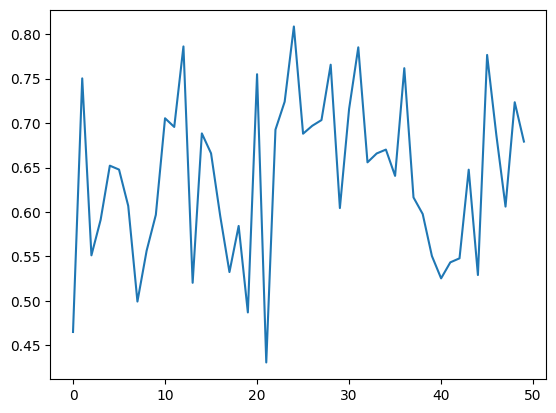

In [37]:
plt.plot(losses)

Our model couldn't converge at all. Now we will try to balance and modify data before the training

## Data balancing

<AxesSubplot: xlabel='class', ylabel='count'>

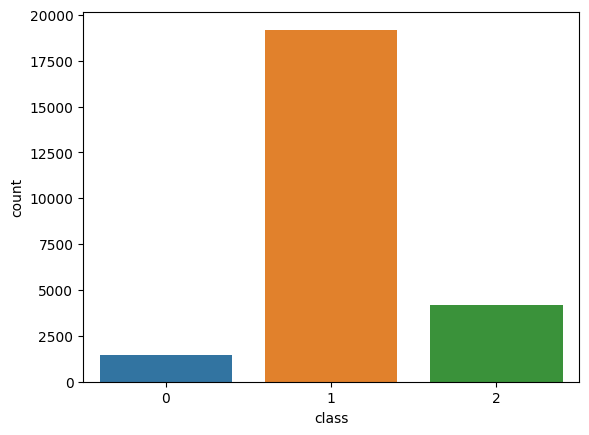

In [39]:
sns.countplot(data=df, x="class")

In [40]:
df

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
24778,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,6,0,6,0,1,youu got wild bitches tellin you lies


In [41]:
df["class"].value_counts()
#undersampling could be the best choice, we have 1430 tweets that was labeled as hate_speech .

1    19190
2     4163
0     1430
Name: class, dtype: int64

In [42]:
remove_neither = 4163 - 1430
remove_offensive = 19190 - 1430

off_df = df[df["class"] == 1] 

hate_df = df[df["class"] == 0]
neither_df = df[df["class"] == 2]

neither_drop_indices = np.random.choice(neither_df.index, remove_neither, replace=False)
offensive_drop_indices = np.random.choice(off_df.index, remove_offensive, replace=False)

neither_undersampled = neither_df.drop(neither_drop_indices)
offensive_undersampled = off_df.drop(offensive_drop_indices)

In [43]:
print(len(neither_undersampled))
print(len(offensive_undersampled))

1430
1430


In [44]:
neither_undersampled

,count,hate_speech,offensive_language,neither,class,tweet
66,3,0,1,2,2,"""@AllAboutManFeet: http://t.co/3gzUpfuMev"" woo..."
75,3,0,1,2,2,"""@BabyAnimalPics: baby monkey bathtime http://..."
118,3,0,0,3,2,"""@DunderbaIl: I'm an early bird and I'm a nigh..."
122,3,0,0,3,2,"""@FloKid88: As long as the Lakers trash from n..."
158,3,0,1,2,2,"""@KeyshawnSwag: Peel up peel up bring it back ..."
...,...,...,...,...,...,...
24659,3,0,0,3,2,what a clam shame
24703,3,0,0,3,2,why they playing trash on ESPN right now.
24709,3,0,0,3,2,wish I had a brownie or a dab to knock me out rn
24721,3,0,0,3,2,wth is that playing missy? ........ i mean ser...


In [45]:
balanced_train_df = pd.concat([hate_df, offensive_undersampled, neither_undersampled])

In [46]:
balanced_train_df["class"].value_counts()

0    1430
1    1430
2    1430
Name: class, dtype: int64

In [47]:
for i in train_encoded[:3]:
    print(i)

([1, 3, 3, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 6, 7, 22, 9, 10, 23, 24, 25, 26, 27, 28, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2)
([1, 3, 3, 3, 3, 3, 4, 5, 29, 30, 31, 28, 32, 33, 34, 35, 36, 37, 38, 39, 25, 40, 41, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1)
([1, 3, 3, 3, 3, 3, 3, 3, 4, 42, 3, 3, 3, 3, 4, 5, 9, 43, 44, 7, 45, 46, 47, 48, 49, 50, 51, 9, 52, 53, 6, 54, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1)


In [59]:
balanced_clean_df = balanced_train_df.drop(['count','hate_speech', 'offensive_language', 'neither'],axis=1)

In [60]:
balanced_clean_df = [(row['class'], word_tokenize(remove_links_mentions(row['tweet']))) for index, row in balanced_clean_df.iterrows()]
balanced_clean_df[:3]

[(0, ['``', ':', 'queer', "''", 'gaywad']),
 (0,
  ['``',
   ':',
   'alsarabsss',
   "''",
   'hes',
   'a',
   'beaner',
   'smh',
   'you',
   'can',
   'tell',
   'hes',
   'a',
   'mexican']),
 (0,
  ['``',
   ':',
   'you',
   "'re",
   'fucking',
   'gay',
   ',',
   'blacklisted',
   'hoe',
   "''",
   'holding',
   'out',
   'for',
   '#',
   'tehgodclan',
   'anyway'])]

In [61]:
index2word = ["<PAD>", "<SOS>", "<EOS>"]

for ds in [balanced_clean_df]:
    for class_, tweet in ds:
        for token in tweet:
            if token not in index2word:
                index2word.append(token)

In [62]:
word2index = {token: idx for idx, token in enumerate(index2word)}

In [63]:
word2index["nigga"]

120

In [79]:
len(index2word)
seq_length = 32

In [80]:
train_encoded = [(encode_and_pad(tweet, seq_length), label) for label, tweet in balanced_clean_df]

In [81]:
X = np.array([elem[0] for elem in train_encoded])
y = np.array([elem[1] for elem in train_encoded])
train_x,test_x,train_y,test_y = train_test_split(X,y,test_size=0.15 ,random_state=10)

In [82]:
batch_size = 32




train_ds = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_ds = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))


train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=batch_size, drop_last=True)

model = BiLSTM_SentimentAnalysis(len(word2index), 64, 32, 0.2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)


In [83]:
for batch_idx, batch in enumerate(train_dl):
    print(len(batch[1]))
    break

32


In [84]:
epochs = 200
losses = []
i = 0
for e in range(epochs):
    i += 1
    epoch_loss = 0.0
    print("Epoch {}".format(i))
    h0, c0 =  model.init_hidden(batch_size)

    h0 = h0.to(device)
    c0 = c0.to(device)

    for batch_idx, batch in enumerate(train_dl):

        input_x = batch[0].to(device)
        target = batch[1].to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            out, hidden = model(input_x, (h0, c0))
            loss = criterion(out, target)
            #print("Batch {} Loss: {:.4f}".format(batch_idx, loss.item()))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_dl)
    print("Epoch {} Average Loss: {:.4f}".format(i, avg_loss))
    losses.append(loss.item())

Epoch 1
Epoch 1 Average Loss: 1.0979
Epoch 2
Epoch 2 Average Loss: 1.0974
Epoch 3
Epoch 3 Average Loss: 1.0976
Epoch 4
Epoch 4 Average Loss: 1.0967
Epoch 5
Epoch 5 Average Loss: 1.0970
Epoch 6
Epoch 6 Average Loss: 1.0974
Epoch 7
Epoch 7 Average Loss: 1.0974
Epoch 8
Epoch 8 Average Loss: 1.0963
Epoch 9
Epoch 9 Average Loss: 1.0964
Epoch 10
Epoch 10 Average Loss: 1.0969
Epoch 11
Epoch 11 Average Loss: 1.0970
Epoch 12
Epoch 12 Average Loss: 1.0966
Epoch 13
Epoch 13 Average Loss: 1.0965
Epoch 14
Epoch 14 Average Loss: 1.0960
Epoch 15
Epoch 15 Average Loss: 1.0978
Epoch 16
Epoch 16 Average Loss: 1.0971
Epoch 17
Epoch 17 Average Loss: 1.0965
Epoch 18
Epoch 18 Average Loss: 1.0960
Epoch 19
Epoch 19 Average Loss: 1.0971
Epoch 20
Epoch 20 Average Loss: 1.0968
Epoch 21
Epoch 21 Average Loss: 1.0963
Epoch 22
Epoch 22 Average Loss: 1.0966
Epoch 23
Epoch 23 Average Loss: 1.0972
Epoch 24
Epoch 24 Average Loss: 1.0975
Epoch 25
Epoch 25 Average Loss: 1.0976
Epoch 26
Epoch 26 Average Loss: 1.0965
Epoc

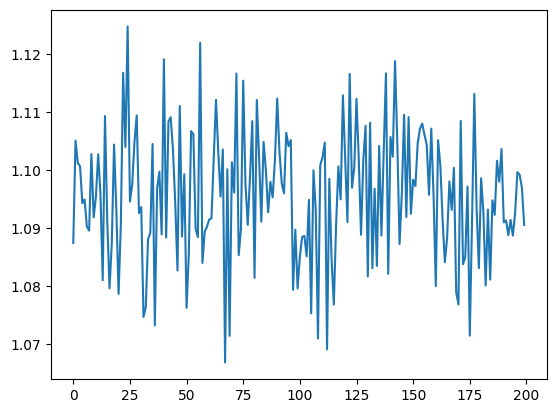

In [85]:
plt.plot(losses)

Our model couldn't converge again. Probable causes should be
        
        